<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/feature%2Fsplit-dataset-into-training-and-testing/SRCNN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
class SRCNN(nn.Module):
    def __init__(self) -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
        n1 = 64
        n2 = 32

        self.model = nn.Sequential(

            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
                      kernel_size=(f1, f1), padding=(f1-1)//2),
            nn.ReLU(),

            # 3.1.2 Non-linear mapping
            nn.Conv2d(in_channels=n1, out_channels=n2,
                      kernel_size=(f2, f2), padding=(f2-1)//2),
            nn.ReLU(),

            # 3.1.3 Reconstruction
            nn.Conv2d(in_channels=n2, out_channels=3,
                      kernel_size=(f3, f3), padding=(f3-1)//2),
        )

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


In [3]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    test_loss /= num_batches

    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


In [4]:

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# garantir que é cuda
assert device == "cuda"

In [6]:
# Instancianting the model
model = SRCNN()
model.to(device)

# hyperparameters
lr = 1e-5

In [7]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, transform = None, target_transform = None):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.file_lst = list(os.listdir(img_dir))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return len(self.file_lst)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
        img_path = self.file_lst[idx]
        image = read_image(f"{self.img_dir}/{img_path}")
        image_x = image.detach().clone()
        image_y = image.detach().clone()
        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)
        return image_x.float() / 255, image_y.float() / 255

In [8]:
class ImageHelper:
    """
    A helper class for working with image data in PyTorch.
    """

    def __init__(self):
        """
        Initializes a new instance of the ImageHelper class.
        """
        return

    def show_tensor_as_image(self, tensor: torch.Tensor):
        """
        Displays an image represented as a PyTorch tensor.

        Args:
            tensor: A PyTorch tensor representing the image. The tensor should have shape (C, H, W),
                where C is the number of channels, H is the height, and W is the width.

        Returns:
            None
        """
        plt.figure()
        tensor_np = tensor.detach().numpy()
        plt.imshow(tensor_np.transpose((1, 2, 0)))
        plt.show()


In [9]:
transform_x = transforms.Compose([
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((33, 33), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    # resize image to 256x256 and downsample by BICUBIC interpolation
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir="/content/drive/MyDrive/TCC/datasets/DIV2K_train_HR", transform=transform_x, target_transform=transform_y)
test_data_set = CustomImageDataset(
    img_dir="/content/drive/MyDrive/TCC/datasets/DIV2K_valid_HR", transform=transform_x, target_transform=transform_y)

train_dataloader = DataLoader(train_data_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size=16)

In [10]:
# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


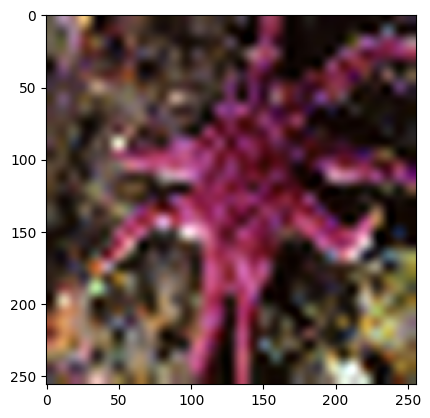

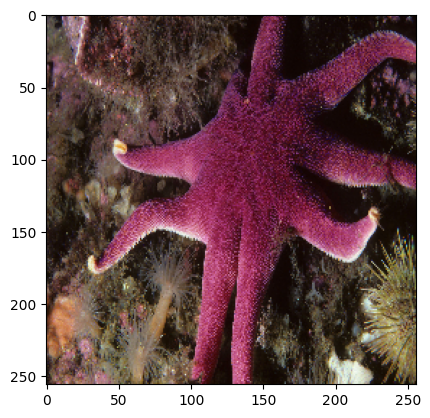

In [11]:
# example of training image
ImageHelperInstance = ImageHelper()

for a, b in train_data_set:
    ImageHelperInstance.show_tensor_as_image(a)
    ImageHelperInstance.show_tensor_as_image(b)
    break

# for X, y in train_dataloader:
#     ImageHelperInstance.show_tensor_as_image(X[0])
#     ImageHelperInstance.show_tensor_as_image(y[0])
#     break


In [12]:
%%time
epochs = 76
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


  2%|▏         | 1/54 [00:59<52:34, 59.51s/it]

loss: 0.258890  [    0/  850]


100%|██████████| 7/7 [01:59<00:00, 17.11s/it]


Test Error: 
 Avg loss: 0.257476 

Epoch 2
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.84s/it]

loss: 0.269043  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.256369 

Epoch 3
-------------------------------


  2%|▏         | 1/54 [00:01<01:41,  1.91s/it]

loss: 0.228760  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.255268 

Epoch 4
-------------------------------


  2%|▏         | 1/54 [00:01<01:39,  1.89s/it]

loss: 0.207971  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


Test Error: 
 Avg loss: 0.254166 

Epoch 5
-------------------------------


  2%|▏         | 1/54 [00:02<02:08,  2.43s/it]

loss: 0.287388  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.253083 

Epoch 6
-------------------------------


  2%|▏         | 1/54 [00:01<01:41,  1.92s/it]

loss: 0.221636  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.251999 

Epoch 7
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.84s/it]

loss: 0.234422  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.250928 

Epoch 8
-------------------------------


  2%|▏         | 1/54 [00:01<01:35,  1.80s/it]

loss: 0.288976  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.249863 

Epoch 9
-------------------------------


  2%|▏         | 1/54 [00:01<01:34,  1.79s/it]

loss: 0.200967  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.248801 

Epoch 10
-------------------------------


  2%|▏         | 1/54 [00:02<02:14,  2.53s/it]

loss: 0.262511  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.247745 

Epoch 11
-------------------------------


  2%|▏         | 1/54 [00:01<01:41,  1.92s/it]

loss: 0.290098  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.246693 

Epoch 12
-------------------------------


  2%|▏         | 1/54 [00:01<01:39,  1.88s/it]

loss: 0.265080  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.245649 

Epoch 13
-------------------------------


  2%|▏         | 1/54 [00:01<01:33,  1.77s/it]

loss: 0.291411  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.244605 

Epoch 14
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.84s/it]

loss: 0.270661  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Test Error: 
 Avg loss: 0.243575 

Epoch 15
-------------------------------


  2%|▏         | 1/54 [00:02<02:03,  2.33s/it]

loss: 0.255775  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.242545 

Epoch 16
-------------------------------


  2%|▏         | 1/54 [00:01<01:31,  1.72s/it]

loss: 0.249546  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.241524 

Epoch 17
-------------------------------


  2%|▏         | 1/54 [00:01<01:40,  1.89s/it]

loss: 0.247990  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.240505 

Epoch 18
-------------------------------


  2%|▏         | 1/54 [00:02<02:15,  2.55s/it]

loss: 0.245423  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Test Error: 
 Avg loss: 0.239491 

Epoch 19
-------------------------------


  2%|▏         | 1/54 [00:01<01:38,  1.86s/it]

loss: 0.237077  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Test Error: 
 Avg loss: 0.238476 

Epoch 20
-------------------------------


  2%|▏         | 1/54 [00:01<01:35,  1.81s/it]

loss: 0.225563  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.237472 

Epoch 21
-------------------------------


  2%|▏         | 1/54 [00:01<01:42,  1.94s/it]

loss: 0.216610  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.236480 

Epoch 22
-------------------------------


  2%|▏         | 1/54 [00:02<01:56,  2.19s/it]

loss: 0.257709  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Test Error: 
 Avg loss: 0.235491 

Epoch 23
-------------------------------


  2%|▏         | 1/54 [00:01<01:39,  1.88s/it]

loss: 0.213134  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.234504 

Epoch 24
-------------------------------


  2%|▏         | 1/54 [00:01<01:35,  1.80s/it]

loss: 0.220364  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.233517 

Epoch 25
-------------------------------


  2%|▏         | 1/54 [00:02<01:46,  2.00s/it]

loss: 0.229223  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Test Error: 
 Avg loss: 0.232538 

Epoch 26
-------------------------------


  2%|▏         | 1/54 [00:02<02:14,  2.55s/it]

loss: 0.224548  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.231567 

Epoch 27
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.84s/it]

loss: 0.200767  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.230605 

Epoch 28
-------------------------------


  2%|▏         | 1/54 [00:01<01:41,  1.91s/it]

loss: 0.209703  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.229639 

Epoch 29
-------------------------------


  2%|▏         | 1/54 [00:01<01:30,  1.70s/it]

loss: 0.295424  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.228664 

Epoch 30
-------------------------------


  2%|▏         | 1/54 [00:02<02:17,  2.59s/it]

loss: 0.268558  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.227706 

Epoch 31
-------------------------------


  2%|▏         | 1/54 [00:01<01:28,  1.67s/it]

loss: 0.215318  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Test Error: 
 Avg loss: 0.226755 

Epoch 32
-------------------------------


  2%|▏         | 1/54 [00:01<01:39,  1.88s/it]

loss: 0.224840  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.225803 

Epoch 33
-------------------------------


  2%|▏         | 1/54 [00:01<01:44,  1.96s/it]

loss: 0.254651  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Test Error: 
 Avg loss: 0.224853 

Epoch 34
-------------------------------


  2%|▏         | 1/54 [00:02<02:02,  2.31s/it]

loss: 0.189605  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Test Error: 
 Avg loss: 0.223910 

Epoch 35
-------------------------------


  2%|▏         | 1/54 [00:01<01:39,  1.87s/it]

loss: 0.233007  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Test Error: 
 Avg loss: 0.222972 

Epoch 36
-------------------------------


  2%|▏         | 1/54 [00:01<01:36,  1.82s/it]

loss: 0.228454  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.222037 

Epoch 37
-------------------------------


  2%|▏         | 1/54 [00:02<01:50,  2.09s/it]

loss: 0.231275  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


Test Error: 
 Avg loss: 0.221099 

Epoch 38
-------------------------------


  2%|▏         | 1/54 [00:02<01:56,  2.19s/it]

loss: 0.201531  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Test Error: 
 Avg loss: 0.220167 

Epoch 39
-------------------------------


  2%|▏         | 1/54 [00:01<01:36,  1.83s/it]

loss: 0.220930  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.219245 

Epoch 40
-------------------------------


  2%|▏         | 1/54 [00:01<01:35,  1.81s/it]

loss: 0.181378  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.218325 

Epoch 41
-------------------------------


  2%|▏         | 1/54 [00:01<01:30,  1.71s/it]

loss: 0.242962  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Test Error: 
 Avg loss: 0.217406 

Epoch 42
-------------------------------


  2%|▏         | 1/54 [00:01<01:41,  1.92s/it]

loss: 0.240264  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.216488 

Epoch 43
-------------------------------


  2%|▏         | 1/54 [00:01<01:32,  1.75s/it]

loss: 0.246392  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.215571 

Epoch 44
-------------------------------


  2%|▏         | 1/54 [00:02<01:50,  2.09s/it]

loss: 0.230340  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Test Error: 
 Avg loss: 0.214659 

Epoch 45
-------------------------------


  2%|▏         | 1/54 [00:02<02:01,  2.30s/it]

loss: 0.221199  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


Test Error: 
 Avg loss: 0.213756 

Epoch 46
-------------------------------


  2%|▏         | 1/54 [00:02<01:55,  2.18s/it]

loss: 0.232605  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Test Error: 
 Avg loss: 0.212857 

Epoch 47
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.85s/it]

loss: 0.231573  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.211960 

Epoch 48
-------------------------------


  2%|▏         | 1/54 [00:01<01:35,  1.80s/it]

loss: 0.197960  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Test Error: 
 Avg loss: 0.211065 

Epoch 49
-------------------------------


  2%|▏         | 1/54 [00:01<01:36,  1.83s/it]

loss: 0.227144  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.210169 

Epoch 50
-------------------------------


  2%|▏         | 1/54 [00:01<01:36,  1.81s/it]

loss: 0.249292  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Test Error: 
 Avg loss: 0.209280 

Epoch 51
-------------------------------


  2%|▏         | 1/54 [00:01<01:32,  1.74s/it]

loss: 0.176511  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.208389 

Epoch 52
-------------------------------


  2%|▏         | 1/54 [00:01<01:31,  1.72s/it]

loss: 0.214594  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.207513 

Epoch 53
-------------------------------


  2%|▏         | 1/54 [00:01<01:41,  1.92s/it]

loss: 0.235718  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.206635 

Epoch 54
-------------------------------


  2%|▏         | 1/54 [00:02<01:51,  2.11s/it]

loss: 0.201448  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.205753 

Epoch 55
-------------------------------


  2%|▏         | 1/54 [00:01<01:32,  1.75s/it]

loss: 0.200079  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.204881 

Epoch 56
-------------------------------


  2%|▏         | 1/54 [00:01<01:38,  1.86s/it]

loss: 0.205123  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.203998 

Epoch 57
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.84s/it]

loss: 0.211082  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.203124 

Epoch 58
-------------------------------


  2%|▏         | 1/54 [00:02<01:58,  2.23s/it]

loss: 0.207166  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Test Error: 
 Avg loss: 0.202256 

Epoch 59
-------------------------------


  2%|▏         | 1/54 [00:02<01:52,  2.13s/it]

loss: 0.175242  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Test Error: 
 Avg loss: 0.201393 

Epoch 60
-------------------------------


  2%|▏         | 1/54 [00:01<01:32,  1.75s/it]

loss: 0.193123  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.200530 

Epoch 61
-------------------------------


  2%|▏         | 1/54 [00:01<01:39,  1.88s/it]

loss: 0.214025  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Test Error: 
 Avg loss: 0.199664 

Epoch 62
-------------------------------


  2%|▏         | 1/54 [00:01<01:40,  1.89s/it]

loss: 0.230135  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.198805 

Epoch 63
-------------------------------


  2%|▏         | 1/54 [00:02<02:08,  2.42s/it]

loss: 0.202126  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.197944 

Epoch 64
-------------------------------


  2%|▏         | 1/54 [00:01<01:39,  1.87s/it]

loss: 0.215028  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.197091 

Epoch 65
-------------------------------


  2%|▏         | 1/54 [00:01<01:36,  1.83s/it]

loss: 0.222927  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Test Error: 
 Avg loss: 0.196238 

Epoch 66
-------------------------------


  2%|▏         | 1/54 [00:01<01:40,  1.89s/it]

loss: 0.224599  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.195388 

Epoch 67
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.85s/it]

loss: 0.215271  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.194538 

Epoch 68
-------------------------------


  2%|▏         | 1/54 [00:01<01:37,  1.84s/it]

loss: 0.204042  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Test Error: 
 Avg loss: 0.193697 

Epoch 69
-------------------------------


  2%|▏         | 1/54 [00:01<01:41,  1.92s/it]

loss: 0.185690  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Test Error: 
 Avg loss: 0.192860 

Epoch 70
-------------------------------


  2%|▏         | 1/54 [00:02<02:03,  2.32s/it]

loss: 0.205587  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


Test Error: 
 Avg loss: 0.192023 

Epoch 71
-------------------------------


  2%|▏         | 1/54 [00:02<02:07,  2.40s/it]

loss: 0.203889  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


Test Error: 
 Avg loss: 0.191190 

Epoch 72
-------------------------------


  2%|▏         | 1/54 [00:02<01:54,  2.17s/it]

loss: 0.191249  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Test Error: 
 Avg loss: 0.190361 

Epoch 73
-------------------------------


  2%|▏         | 1/54 [00:01<01:31,  1.73s/it]

loss: 0.188859  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.189538 

Epoch 74
-------------------------------


  2%|▏         | 1/54 [00:01<01:33,  1.76s/it]

loss: 0.181665  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.86s/it]


Test Error: 
 Avg loss: 0.188709 

Epoch 75
-------------------------------


  2%|▏         | 1/54 [00:01<01:33,  1.77s/it]

loss: 0.178883  [    0/  850]


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Test Error: 
 Avg loss: 0.187890 

Epoch 76
-------------------------------


  2%|▏         | 1/54 [00:02<01:47,  2.02s/it]

loss: 0.151502  [    0/  850]


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]

Test Error: 
 Avg loss: 0.187066 

Done!
CPU times: user 2h 12min 17s, sys: 3min 33s, total: 2h 15min 50s
Wall time: 2h 26min 6s


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x361 at 0x7F7DAD2E2A00>


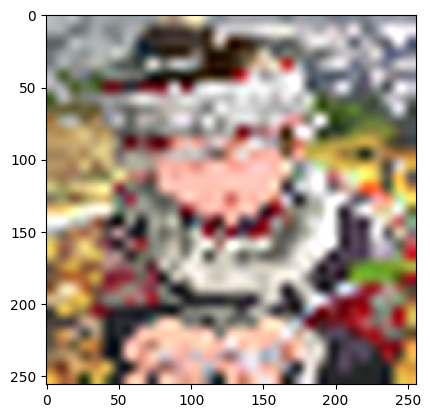

In [13]:
new_image = Image.open('/content/drive/MyDrive/TCC/datasets/Set14/comic.png')
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((33, 33), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.BICUBIC)
])


new_image_lr = transform(new_image)
print(new_image)
ImageHelperInstance.show_tensor_as_image(new_image_lr)


In [14]:
new_image_sr = model(new_image_lr.to(device))

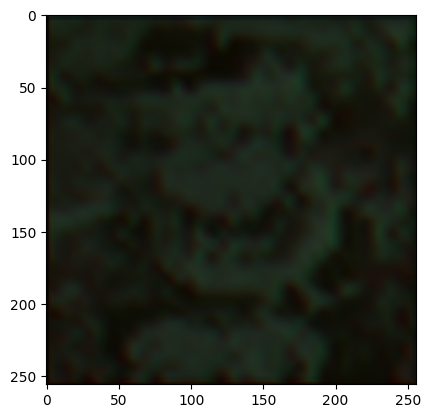

In [15]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()